#Machine Learning Sentiment Analysis (TF-IDF, Bag of Words, Textblob)

In this notebook Sentiment Analysis is done for the Disneyland reviews dataset using different Machine Learning techniques.

You will see:
- Dataset transformation from ratings 1-5 to positive-negative labelling and balancing the classes.
- Text pre-processing: removing stopwords, removing special characters, stemming.
- Bag of Words and TF-idf models with Logistic Regression.
- Bag of Words and TF-idf models with Multinomial Naive Bayes.
- Using Textblob library pre-trained sentiment analysis model for predicting the test set.


**Import libraries**

In [2]:
#Load the libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer

import spacy
import re,string,unicodedata

from textblob import TextBlob
from textblob import Word

**Load the Disneyland reviews dataset**

In [3]:
# read data from csv
disneyland_data=pd.read_csv('DisneylandReviews.csv', encoding="cp1252")
print(disneyland_data.shape)
disneyland_data.head(10)

(42656, 6)


,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong
5,670591897,3,2019-4,Singapore,"Have been to Disney World, Disneyland Anaheim ...",Disneyland_HongKong
6,670585330,5,2019-4,India,Great place! Your day will go by and you won't...,Disneyland_HongKong
7,670574142,3,2019-3,Malaysia,Think of it as an intro to Disney magic for th...,Disneyland_HongKong
8,670571027,2,2019-4,Australia,"Feel so let down with this place,the Disneylan...",Disneyland_HongKong
9,670570869,5,2019-3,India,I can go on talking about Disneyland. Whatever...,Disneyland_HongKong


**Positive/Negative split**

In [4]:
# assign positive label (1) for ratings from 1 to 3 and negative label (0) for ratings 1 and 2
disneyland_data["Sentiment"] = disneyland_data["Rating"].apply(lambda score: "positive" if score >= 3 else "negative")
disneyland_data['Sentiment'] = disneyland_data['Sentiment'].map({'positive':1, 'negative':0})
sentiment_data = disneyland_data[["Review_Text", "Sentiment"]]

In [5]:
# sentiment count to see if the dataset is balanced or not
sentiment_data['Sentiment'].value_counts()

1    39030
0     3626
Name: Sentiment, dtype: int64

The dataset is not balanced, so let's take a random sample from the positive label reviews and create a balanced dataset. 

In [6]:
# select positive reviews
positive_data = sentiment_data[sentiment_data['Sentiment'] == 1]
# take a sample size 4000 from the positive reviews
positive_sample = positive_data.sample(4000, random_state=123)
# select negative reviews
negative_data = sentiment_data[sentiment_data['Sentiment'] == 0]

In [7]:
# create new balanced dataset
data = positive_sample.append(negative_data)
# shuffle the rows from the dataset
data = data.sample(frac=1, random_state=123).reset_index(drop=True)

In [8]:
data['Sentiment'].value_counts()

1    4000
0    3626
Name: Sentiment, dtype: int64

Now the dataset is balanced.

**Train/Test split**

In [9]:
# split the dataset (80% for the train data and 20% for test data)

#train dataset 
train_reviews=data.Review_Text[:6100]
train_sentiments=data.Sentiment[:6100]

#test dataset
test_reviews=data.Review_Text[6100:]
test_sentiments=data.Sentiment[6100:]

print(train_reviews.shape,train_sentiments.shape)
print(test_reviews.shape,test_sentiments.shape)

(6100,) (6100,)
(1526,) (1526,)


##Text preprocessing

In [10]:
nltk.download('stopwords')
#Tokenization of text
tokenizer=ToktokTokenizer()
# Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Removing special characters**

In [11]:
# function for removing special characters (characters that are not letters or numbers)
def remove_special_characters(text):
    pattern = r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

# function for removing extra blank spaces (when there is more than one blank just replace with one)
def remove_extra_blank_spaces(text):
  return re.sub(' +', ' ', text)

#Apply functions on review column
data['Review_Text'] = data['Review_Text'].apply(remove_special_characters)
data['Review_Text'] = data['Review_Text'].apply(remove_extra_blank_spaces)

**Text stemming**

In [12]:
# Stemming the text function
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
    
# Apply function on review column
data['Review_Text'] = data['Review_Text'].apply(simple_stemmer)

**Removing stopwords**

In [13]:
# set stopwords to english
stop=set(stopwords.words('english'))

# removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

# Apply function on review column
data['Review_Text'] = data['Review_Text'].apply(remove_stopwords)

**Normalized train reviews**

In [14]:
#normalized train reviews
norm_train_reviews=data.Review_Text[:6100]
norm_train_reviews[5]

'wa great vacat daughter 15 11 enjoy everyth crowd wa light employe disney veri friendli properti wa veri clean'

**Normalized test reviews**

In [15]:
# Normalized test reviews
norm_test_reviews=data.Review_Text[6100:]
norm_test_reviews[6102]

'havent visit disneyland christma miss one greatest attract california immers christma spirit haunt mansion wonder halloween christma collid'

##Bags of words model

This model is used to convert text documents to numerical vectors or bag of words.

In [16]:
# Count vectorizer for bag of words
cv = CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))

# transformed train reviews
cv_train_reviews = cv.fit_transform(norm_train_reviews)
# transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (6100, 615100)
BOW_cv_test: (1526, 615100)


##Term Frequency-Inverse Document Frequency model (TF-IDF)

This model is used to convert text documents to  matrix of tfidf features.

In [17]:
# Tfidf vectorizer
tv = TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))

# transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
# transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)

print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (6100, 615100)
Tfidf_test: (1526, 615100)


**Labeling the sentiment text**

In [18]:
#labeling the sentiment data
lb = LabelBinarizer()
# transformed sentiment data
sentiment_data = lb.fit_transform(data['Sentiment'])
print(sentiment_data.shape)

(7626, 1)


**Split the sentiment data**

In [19]:
# Spliting the sentiment data
train_sentiments=sentiment_data[:6100]
test_sentiments=sentiment_data[6100:]

##Logistic Regression model performance for Bag of Words and TF-idf features

Building a logistic regression model for both bag of words and tfidf features.

In [20]:
# training the model
lr = LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=123)

# Fitting the model for Bag of words
lr_bow = lr.fit(cv_train_reviews, train_sentiments)

# Fitting the model for tfidf features
lr_tfidf = lr.fit(tv_train_reviews, train_sentiments)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
# Predicting the model for bag of words
lr_bow_predict = lr.predict(cv_test_reviews)

# Predicting the model for tfidf features
lr_tfidf_predict = lr.predict(tv_test_reviews)

**Accuracy of the model**

In [22]:
# Accuracy score for bag of words
lr_bow_score = accuracy_score(test_sentiments, lr_bow_predict)
print("lr_bow_accuracy :",lr_bow_score)

# Accuracy score for tfidf features
lr_tfidf_score = accuracy_score(test_sentiments, lr_tfidf_predict)
print("lr_tfidf_accuracy :",lr_tfidf_score)

lr_bow_accuracy : 0.716251638269987
lr_tfidf_accuracy : 0.5812581913499345


**Print the classification report**

In [23]:
# Classification report for bag of words 
lr_bow_report = classification_report(test_sentiments, lr_bow_predict, target_names=['Positive','Negative'])
print(lr_bow_report)

# Classification report for tfidf features
lr_tfidf_report = classification_report(test_sentiments, lr_tfidf_predict, target_names=['Positive','Negative'])
print(lr_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.58      0.65       709
    Negative       0.70      0.83      0.76       817

    accuracy                           0.72      1526
   macro avg       0.72      0.71      0.71      1526
weighted avg       0.72      0.72      0.71      1526

              precision    recall  f1-score   support

    Positive       0.84      0.12      0.21       709
    Negative       0.56      0.98      0.71       817

    accuracy                           0.58      1526
   macro avg       0.70      0.55      0.46      1526
weighted avg       0.69      0.58      0.48      1526



**Confusion matrices**

Text(33.0, 0.5, 'Truth')

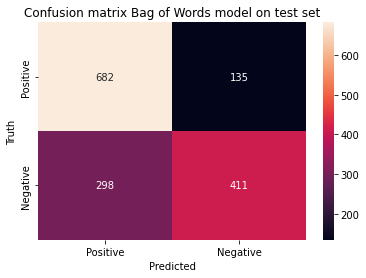

In [24]:
#confusion matrix for bag of words 
cm_bow=confusion_matrix(test_sentiments, lr_bow_predict, labels=[1,0])

ax = sns.heatmap(cm_bow, annot=True, fmt='d')
plt.title('Confusion matrix Bag of Words model on test set')
ax.xaxis.set_ticklabels(['Positive','Negative'])
ax.yaxis.set_ticklabels(['Positive','Negative'])
plt.xlabel('Predicted')
plt.ylabel('Truth')

Text(33.0, 0.5, 'Truth')

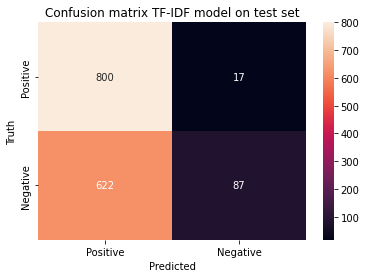

In [25]:
# confusion matrix for tfidf features
cm_tfidf = confusion_matrix(test_sentiments, lr_tfidf_predict, labels=[1,0])

ax = sns.heatmap(cm_tfidf, annot=True, fmt='d')
plt.title('Confusion matrix TF-IDF model on test set')
ax.xaxis.set_ticklabels(['Positive','Negative'])
ax.yaxis.set_ticklabels(['Positive','Negative'])
plt.xlabel('Predicted')
plt.ylabel('Truth')

##Multinomial Naive Bayes for Bag of Words and TF-idf features

In [26]:
# training the model
mnb = MultinomialNB()

# fitting the svm for bag of words
mnb_bow = mnb.fit(cv_train_reviews, train_sentiments)

# fitting the svm for tfidf features
mnb_tfidf = mnb.fit(tv_train_reviews, train_sentiments)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**Model performance on test data**

In [27]:
# Predicting the model for bag of words
mnb_bow_predict = mnb.predict(cv_test_reviews)

# Predicting the model for tfidf features
mnb_tfidf_predict = mnb.predict(tv_test_reviews)

**Accuracy of the model**

In [28]:
# Accuracy score for bag of words
mnb_bow_score = accuracy_score(test_sentiments, mnb_bow_predict)
print("mnb_bow_accuracy :", mnb_bow_score)

# Accuracy score for tfidf features
mnb_tfidf_score = accuracy_score(test_sentiments, mnb_tfidf_predict)
print("mnb_tfidf_accuracy :", mnb_tfidf_score)

mnb_bow_accuracy : 0.7201834862385321
mnb_tfidf_accuracy : 0.6520314547837484


**Print the classification report**

In [29]:
# Classification report for bag of words 
mnb_bow_report = classification_report(test_sentiments, mnb_bow_predict, target_names=['Positive','Negative'])
print(mnb_bow_report)

#Classification report for tfidf features
mnb_tfidf_report = classification_report(test_sentiments, mnb_tfidf_predict, target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.59      0.66       709
    Negative       0.70      0.83      0.76       817

    accuracy                           0.72      1526
   macro avg       0.73      0.71      0.71      1526
weighted avg       0.73      0.72      0.72      1526

              precision    recall  f1-score   support

    Positive       0.77      0.35      0.49       709
    Negative       0.62      0.91      0.74       817

    accuracy                           0.65      1526
   macro avg       0.70      0.63      0.61      1526
weighted avg       0.69      0.65      0.62      1526



**Plot confusion matrices**

Text(33.0, 0.5, 'Truth')

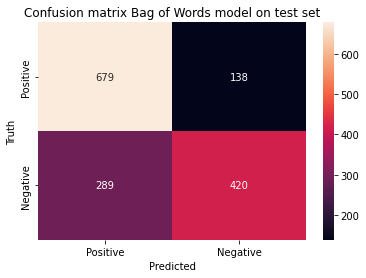

In [30]:
# confusion matrix for bag of words
cm_bow = confusion_matrix(test_sentiments, mnb_bow_predict, labels=[1,0])

ax = sns.heatmap(cm_bow, annot=True, fmt='d')
plt.title('Confusion matrix Bag of Words model on test set')
ax.xaxis.set_ticklabels(['Positive','Negative'])
ax.yaxis.set_ticklabels(['Positive','Negative'])
plt.xlabel('Predicted')
plt.ylabel('Truth')

Text(33.0, 0.5, 'Truth')

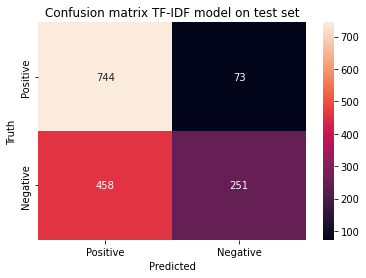

In [31]:
# confusion matrix for tfidf features
cm_tfidf = confusion_matrix(test_sentiments, mnb_tfidf_predict, labels=[1,0])

ax = sns.heatmap(cm_tfidf, annot=True, fmt='d')
plt.title('Confusion matrix TF-IDF model on test set')
ax.xaxis.set_ticklabels(['Positive','Negative'])
ax.yaxis.set_ticklabels(['Positive','Negative'])
plt.xlabel('Predicted')
plt.ylabel('Truth')

##TextBlob

TextBlob Python library has a pre-trained sentiment prediction model.

In [32]:
# refresh the data variable without text treatment
data = positive_sample.append(negative_data)
# shuffle the rows from the dataset
data = data.sample(frac=1, random_state=123).reset_index(drop=True)

# select test data
test_reviews = data.Review_Text[6100:]
test_labels = data.Sentiment[6100:]

# iterate over the reviews calling the TextBlob library for sentiment analysis 
list_predict = []
for review in test_reviews:
  blob = TextBlob(review)
  list_predict.append(blob.sentiment.polarity)

# assign labels for predicted values (TextBlob returns them between -1 and 1)
textblob_predict = np.array(list_predict)
textblob_predict[textblob_predict >= 0] = 1
textblob_predict[textblob_predict < 0] = 0

# compute accuracy
textblob_score = accuracy_score(test_labels, textblob_predict)
print("TextBlob accuracy on test set:",textblob_score)

TextBlob accuracy on test set: 0.6762778505897772


## Conclusion
Here is a summary of the results obtained for the test set by each of the models trained:

| Model | Accuracy on test set
| --- | --- |
| Logistic Regression Bag of Words | 0.7163
| Logistic Regression TF-IDF | 0.5813
| Multinomial Naive Bayes Bag of Words | 0.7202
| Multinomial Naive Bayes TF-IDF | 0.6520
| TextBlob library predict | 0.6762


- Bag of Word seems to perform better than TF-IDF.
- Multinomial Naive Bayes does better than logistic regression model in this classification task.
- TextBlob library that is supposed to have a good pretrained model for sentiment analysis, doesn't get better results for the classification task of this particular dataset.